# Нейронная сеть учится понимать сигналы светофора

Задача проста: у нас есть светофор, и мы хотим научить модель решать, можно ли продолжать движение на перекрестке в зависимости от того, какой сигнал светофора горит. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

## Представление данных

Начнём с представления сигналов светофора. Применим **One-Hot** кодирование для каждого сигнала. Всего у нас есть 6 вариантов сигналов светофора: 1 - зеленый, 2 - зеленый мигающий, 3 - желтый, 4 - желтый мигающий, 5 – красный, 6 - красный мигающий. Для каждого сигнала светофора есть метка: 1 (разрешено движение) или 0 (запрещено). Таким образом, если горит только Зеленый, то численно этот сигнал будет представлен так: [1, 0, 0, 0, 0, 0, 0]. Зеленый мигающий: [0, 1, 0, 0, 0, 0, 0].  Зеленый и желтый: [0, 0, 1, 0, 0, 1].

In [2]:
# Данные: светофор (зеленый, желтый, красный) закодированы как One-Hot векторы
X = np.array([
    [1, 0, 0, 0, 0, 0],  # Зеленый
    [0, 1, 0, 0, 0, 0],  # Зеленый мигающий
    [0, 0, 1, 0, 0, 0],  # Желтый
    [0, 0, 0, 1, 0, 0],  # Желтый мигающий
    [0, 0, 0, 0, 1, 0],  # Красный
    [0, 0, 0, 0, 0, 1],  # Красный мигающий
    [0, 0, 1, 0, 1, 0],  # Красный и желтый
])

In [3]:
# Метки: движение разрешено (1) или запрещено (0)
y = np.array([
    1,  # Зеленый: движение разрешено
    1,  # Зеленый мигающий: движение разрешено
    0,  # Желтый: движение запрещено
    1,  # Желтый мигающий: движение разрешено
    0,  # Красный: движение запрещено
    0,  # Красный мигающий: движение запрещено
    0   # Красный и желтый: движение запрещено
])

## Определение архитектуры сети

Создадим простую нейронную сеть с одним скрытым слоем. В этой сети будет 6 входных нейронов (по числу сигналов светофора), 8 нейронов в скрытом слое (их количество можно поменять) и 1 выходной нейрон, который скажет нам, разрешено ли движение.
Опишем «вручную» функцию, которая обучает нейронную сеть **методом градиентного спуска**. В каждом цикле (эпохе) она выполняет прямой проход для расчета предсказаний, затем вычисляет ошибку между предсказанными и реальными значениями. После этого выполняется обратный проход для расчета градиентов, чтобы корректировать веса сети на основе ошибки. Веса обновляются с использованием производной функции активации и заданной скорости обучения.

**Прямой проход** — это процесс, при котором данные последовательно передаются через сеть, начиная с входного слоя, затем через скрытый слой, и, наконец, к выходному. На выходе мы получаем предсказание.

**Обратный проход** (или Backpropagation) — это ключевой процесс, который используется для обучения нейронной сети. Он заключается в корректировке весов на основе ошибки между реальным результатом и предсказанием сети.

In [4]:
def train_model(epochs, X, y, weights_input_hidden, weights_hidden_output, learning_rate, activation_function, activation_derivative):
    errors = []  # Список для хранения ошибок на каждой эпохе
    
    for epoch in range(epochs):
        # Прямой проход
        hidden_layer_input = np.dot(X, weights_input_hidden)
        hidden_layer_output = activation_function(hidden_layer_input)

        final_input = np.dot(hidden_layer_output, weights_hidden_output)
        final_output = activation_function(final_input)

        # Расчет ошибки
        error = y.reshape(-1, 1) - final_output  # Приводим y к нужной форме

        # Сохранение ошибки для визуализации
        errors.append(np.mean(np.abs(error)))

        # Обратный проход (Backpropagation)
        d_output = error * activation_derivative(final_output)  # Ошибка на выходном слое
        error_hidden_layer = d_output.dot(weights_hidden_output.T)  # Ошибка на скрытом слое
        d_hidden_layer = error_hidden_layer * activation_derivative(hidden_layer_output)  # Градиенты скрытого слоя

        # Обновление весов
        weights_hidden_output += hidden_layer_output.T.dot(d_output) * learning_rate
        weights_input_hidden += X.T.dot(d_hidden_layer) * learning_rate
    
    return weights_input_hidden, weights_hidden_output, errors

Функция активации (например, сигмоида) преобразует входы сети, а её производная помогает понять, насколько быстро сеть должна учиться. Сигмоида преобразует значения в диапазон от 0 до 1. Эта функция хорошо подходит для задач, где результатом является вероятность.

In [5]:
# Сигмоида для активации
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Производная сигмоиды для градиентного спуска
def sigmoid_derivative(x):
    return x * (1 - x)

## Инициализация весов

Обучение сети начинается с инициализации весов случайными значениями. Если произошло чудо и веса, расставленные случайным образом, оказались наилучшие, то модели даже учиться не придется. Если веса уже почти оптимальны, то модель не будет значительно изменять их во время обучения, так как градиентный спуск не сможет внести существенных улучшений. Градиенты будут малы, и обновления весов будут минимальными, что приведет к быстрому завершению процесса обучения. Однако, это идеализированный сценарий, который редко встречается на практике, так как вероятность случайного нахождения оптимальных весов с самого начала крайне мала. Обычно инициализация весов используется для того, чтобы помочь модели начать обучение, а не для нахождения оптимального решения сразу.

In [6]:
# Инициализация случайных весов вначале
np.random.seed(2024)
weights_input_hidden = np.random.rand(6, 8)  # Входной слой -> Скрытый слой (6 нейронов входа, 8 нейронов скрытого слоя)
weights_hidden_output = np.random.rand(8, 1)  # Скрытый слой -> Выходной слой (8 нейронов скрытого слоя, 1 нейрон выхода)

## Обучение модели

Теперь, когда есть функции для прямого и обратного прохода, можно приступить к обучению созданной сети. Установим начальную скорость обучения (learning_rate) и количество эпох (итераций обучения, epochs), чтобы сеть смогла постепенно улучшать свои прогнозы.

In [7]:
# Параметры обучения
learning_rate = 0.1  # Скорость обучения
epochs = 100  # Количество итераций обучения

In [8]:
# Обучение модели
weights_input_hidden, weights_hidden_output, errors = train_model(
    epochs,
    X,
    y,
    weights_input_hidden,
    weights_hidden_output,
    learning_rate,
    sigmoid,
    sigmoid_derivative
)

## Визуализация ошибок

Для того чтобы оценить, как хорошо обучалась модель, можно построить график ошибок по эпохам. Это поможет нам понять, насколько эффективно сеть минимизировала ошибку в процессе обучения.

In [9]:
# Визуализация ошибок
def train_plot(errors):
    plt.figure(figsize=(10, 3))
    plt.plot(errors)
    plt.title("Ошибка модели по эпохам")
    plt.xlabel("Эпохи")
    plt.ylabel("Ошибка")
    plt.grid(True)
    plt.show()

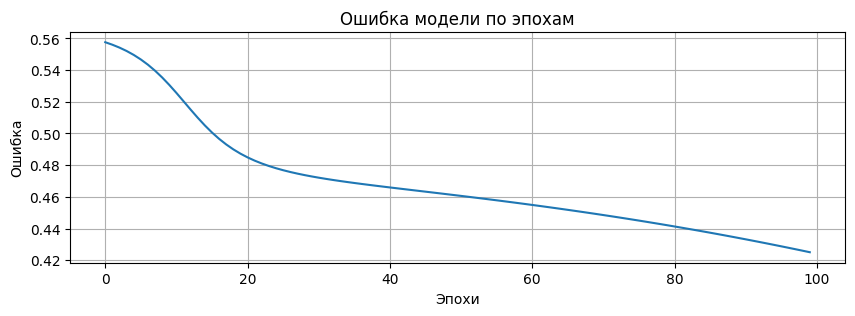

In [10]:
train_plot(errors) # Вызов функции построения графика

## Тестирование модели

Проверим, как созданная нейронная сеть работает на тех же данных, которые использовались для обучения. Протестируем ее, проведем прямой проход через сеть и посмотрим на предсказания.

In [11]:
# Функция для получения предсказаний модели
def predict(input_data, weights_input_hidden, weights_hidden_output):
    hidden_layer_input = np.dot(input_data, weights_input_hidden)  # Прямой проход через скрытый слой
    hidden_layer_output = sigmoid(hidden_layer_input)  # Активация скрытого слоя

    final_input = np.dot(hidden_layer_output, weights_hidden_output)  # Прямой проход к выходу
    final_output = sigmoid(final_input)  # Активация выходного слоя

    return final_output

Тестовые данные представлены так же, как и те, на которых модель училась, это просто для проверки. Поменяем их потом.

In [12]:
# Прогнозы
test_data = np.array([
    [1, 0, 0, 0, 0, 0],  # Зеленый
    [0, 1, 0, 0, 0, 0],  # Зеленый мигающий
    [0, 0, 1, 0, 0, 0],  # Желтый
    [0, 0, 0, 1, 0, 0],  # Желтый мигающий
    [0, 0, 0, 0, 1, 0],  # Красный
    [0, 0, 0, 0, 0, 1],  # Красный мигающий
    [0, 0, 1, 0, 1, 0],  # Красный и желтый
])

In [13]:
predictions = predict(test_data, weights_input_hidden, weights_hidden_output)
rounded_predictions = np.round(predictions)  # Округление предсказаний до 0 или 1

Сформируем таблицу результатов для наглядности:

In [14]:
# Вывод предсказаний и реальных меток в виде таблицы
df = pd.DataFrame({
    "Показания светофора (One-Hot)": [str(row) for row in test_data],
    "Прогноз (вероятность)": predictions.flatten(),
    "Результат модели (разрешено движение/запрещено)": rounded_predictions.flatten(),
    "Правильный результат": y
})

In [15]:
df

,Показания светофора (One-Hot),Прогноз (вероятность),Результат модели (разрешено движение/запрещено),Правильный результат
0,[1 0 0 0 0 0],0.505300,1.0,1
1,[0 1 0 0 0 0],0.533771,1.0,1
2,[0 0 1 0 0 0],0.369547,0.0,0
3,[0 0 0 1 0 0],0.492536,0.0,1
4,[0 0 0 0 1 0],0.410145,0.0,0
5,[0 0 0 0 0 1],0.385091,0.0,0
6,[0 0 1 0 1 0],0.335325,0.0,0


## Оценка качества модели


In [16]:
# Прогнозы
X_test = np.array([
    [1, 0, 0, 0, 0, 0],  # Зеленый
    [0, 1, 0, 0, 0, 0],  # Зеленый мигающий
    [0, 0, 1, 0, 0, 0],  # Желтый
    [0, 0, 0, 1, 0, 0],  # Желтый мигающий
    [0, 0, 0, 0, 1, 0],  # Красный
    [0, 0, 0, 0, 0, 1],  # Красный мигающий
    [0, 0, 1, 0, 1, 0],  # Красный и желтый
])

In [17]:
# Метки: движение разрешено (1) или запрещено (0)
y_test = np.array([
    1,  # Зеленый: движение разрешено
    1,  # Зеленый мигающий: движение разрешено
    0,  # Желтый: движение запрещено
    1,  # Желтый мигающий: движение разрешено
    0,  # Красный: движение запрещено
    0,  # Красный мигающий: движение запрещено
    0   # Красный и желтый: движение запрещено
])

In [18]:
predictions = predict(X_test, weights_input_hidden, weights_hidden_output)
rounded_predictions = np.round(predictions)  # Округление предсказаний до 0 или 1

In [19]:
# Вывод предсказаний и реальных меток в виде таблицы
df_test = pd.DataFrame({
    "Показания светофора (One-Hot)": [str(row) for row in test_data],
    "Прогноз (вероятность)": predictions.flatten(),
    "Результат модели (разрешено движение/запрещено)": rounded_predictions.flatten(),
    "Правильный результат": y_test.flatten()
})

In [20]:
df_test

,Показания светофора (One-Hot),Прогноз (вероятность),Результат модели (разрешено движение/запрещено),Правильный результат
0,[1 0 0 0 0 0],0.505300,1.0,1
1,[0 1 0 0 0 0],0.533771,1.0,1
2,[0 0 1 0 0 0],0.369547,0.0,0
3,[0 0 0 1 0 0],0.492536,0.0,1
4,[0 0 0 0 1 0],0.410145,0.0,0
5,[0 0 0 0 0 1],0.385091,0.0,0
6,[0 0 1 0 1 0],0.335325,0.0,0


### Метрики качества модели

Основные метрики для оценки качества модели в задачах классификации:
- Accuracy (Точность) — доля правильных предсказаний модели от общего числа. Оценивает, насколько модель в целом верно предсказывает метки классов.
- Recall (Полнота) — доля верно предсказанных положительных классов среди всех реальных положительных. Показывает, насколько хорошо модель находит все положительные примеры.
- Precision (Точность предсказания) — доля верно предсказанных положительных классов среди всех предсказанных положительных. Оценивает точность предсказания положительных классов.
- F1 Score — гармоническое среднее между Precision и Recall, даёт сбалансированную оценку между этими двумя метриками, особенно полезно при несбалансированных классах.

In [21]:
def accuracy(y_true, y_pred):
    y_pred = np.round(y_pred)  # Округление предсказаний до 0 или 1
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

In [22]:
def recall(y_true, y_pred):
    y_pred = np.round(y_pred)
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))
    return true_positive / (true_positive + false_negative)

In [23]:
def precision(y_true, y_pred):
    y_pred = np.round(y_pred)
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    return true_positive / (true_positive + false_positive)

In [24]:
def f1__score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec)

In [25]:
acc = accuracy(y_test, predictions.flatten())
print(f'Accuracy: {acc:.3f}')

rec = recall(y_test, predictions.flatten())
print(f'Recall: {rec:.3f}')

prec = precision(y_test, predictions.flatten())
print(f'Precision: {prec:.3f}')

f1 = f1__score(y_test, predictions.flatten())
print(f'F1 Score: {f1:.3f}')

Accuracy: 0.857
Recall: 0.667
Precision: 1.000
F1 Score: 0.800


## Дообучение модели

После обучения модели ее обычно сохраняют для дальнейшего использования – предсказаний на новых данных, или дополнительного обучения.

In [26]:
# Функция сохранения модели на диск
def save_model(weights_input_hidden, weights_hidden_output, filename="model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump((weights_input_hidden, weights_hidden_output), f)
    print(f"Модель сохранена на диске в файл: {filename}")

In [27]:
# Вызов функции сохранения модели
save_model(weights_input_hidden, weights_hidden_output, 'model.pkl')

Модель сохранена на диске в файл: model.pkl


Если модель недостаточно обучена и (или) ее нужно дообучить на новых данных, используется загрузка параметров модели. Опять-таки, есть стандартные методы из библиотек, но у нас будет своя функция load_model:

In [28]:
# Функция загрузки модели
def load_model(filename="model.pkl"):
    with open(filename, 'rb') as f:
        weights_input_hidden, weights_hidden_output = pickle.load(f)
    print(f"Модель загружена из файла: {filename}")
    return weights_input_hidden, weights_hidden_output

In [29]:
# Загрузка модели
weights_input_hidden, weights_hidden_output = load_model('model.pkl')

Модель загружена из файла: model.pkl


In [30]:
# Продолжение обучения загруженной модели
additional_epochs = 1000  # Количество дополнительных эпох

In [31]:
weights_input_hidden, weights_hidden_output, errors = train_model(
    additional_epochs,
    X,
    y,
    weights_input_hidden,
    weights_hidden_output,
    learning_rate,
    sigmoid,
    sigmoid_derivative
)

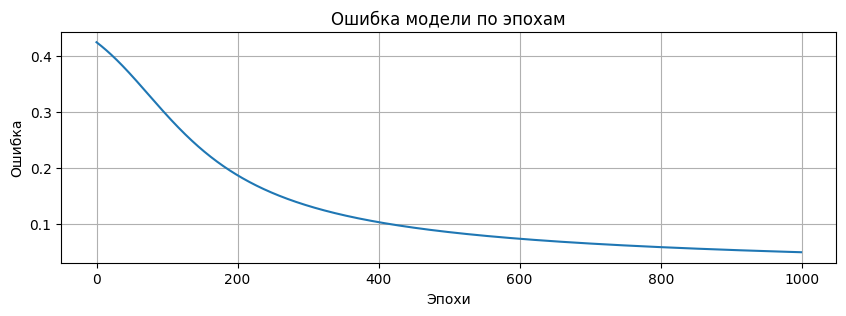

In [32]:
# Визуализация ошибок после дообучения
train_plot(errors)

In [33]:
# Сохранение модели после продолжения обучения
save_model(weights_input_hidden, weights_hidden_output, "model_continued.pkl")

Модель сохранена на диске в файл: model_continued.pkl


In [34]:
# Загрузка модели
weights_input_hidden, weights_hidden_output = load_model("model_continued.pkl")

Модель загружена из файла: model_continued.pkl


In [35]:
# Продолжение обучения загруженной модели
additional_epochs = 3000  # Количество дополнительных эпох

In [36]:
weights_input_hidden, weights_hidden_output, errors = train_model(
    additional_epochs,
    X,
    y,
    weights_input_hidden,
    weights_hidden_output,
    learning_rate,
    sigmoid,
    sigmoid_derivative
)

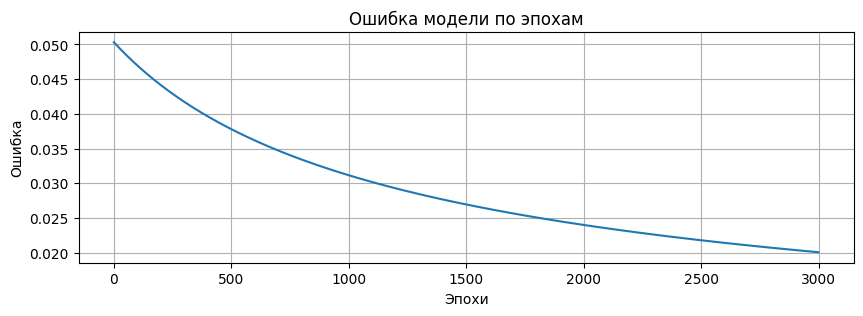

In [37]:
# Визуализация ошибок после второго этапа дообучения
train_plot(errors)

In [38]:
# Сохранение модели после продолжения обучения
save_model(weights_input_hidden, weights_hidden_output, "model_continued.pkl")

Модель сохранена на диске в файл: model_continued.pkl


In [39]:
predictions_1 = predict(X_test, weights_input_hidden, weights_hidden_output)

In [40]:
acc = accuracy(y_test, predictions_1.flatten())
print(f'Accuracy: {acc:.3f}')

rec = recall(y_test, predictions_1.flatten())
print(f'Recall: {rec:.3f}')

prec = precision(y_test, predictions_1.flatten())
print(f'Precision: {prec:.3f}')

f1 = f1__score(y_test, predictions_1.flatten())
print(f'F1 Score: {f1:.3f}')

Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


# Увеличение количества нейронов

Базовую модель нейронной сети уже есть, теперь попробуем ее улучшить. Увеличив количество нейронов, увеличивается её сложность, при этом можно повысить точность предсказаний. Увеличение числа нейронов в скрытом слое позволяет сети выявлять более сложные паттерны в данных.
В нашей базовой модели было 8 нейронов в скрытом слое. В новой версии увеличили их число до 20.  Для этого достаточно изменить инициализацию слоев:

In [41]:
# Инициализация случайных весов вначале
np.random.seed(2024)
weights_input_hidden = np.random.rand(6, 20)  # Входной слой -> Скрытый слой (6 нейронов входа, 20 нейронов скрытого слоя)
weights_hidden_output = np.random.rand(20, 1)  # Скрытый слой -> Выходной слой (20 нейронов скрытого слоя, 1 нейрон выхода)

Остальная часть кода остается без изменений. Вызываем в том же порядке функции train_model, train_plot, predict. Количество эпох в обучении зададим сразу 3000.

In [42]:
# Параметры обучения
learning_rate = 0.1  # Скорость обучения
epochs = 3000  # Количество итераций обучения

In [43]:
# Обучение модели
weights_input_hidden, weights_hidden_output, errors = train_model(
    epochs,
    X,
    y,
    weights_input_hidden,
    weights_hidden_output,
    learning_rate,
    sigmoid,
    sigmoid_derivative
)

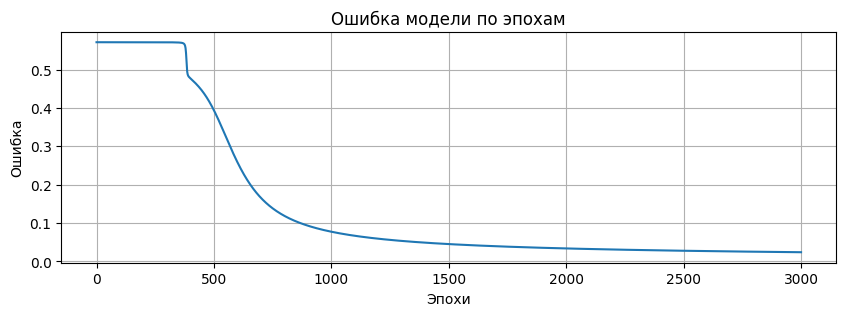

In [44]:
train_plot(errors)

In [45]:
predictions_2 = predict(test_data, weights_input_hidden, weights_hidden_output)
rounded_predictions_2 = np.round(predictions_2)  # Округление предсказаний до 0 или 1

In [46]:
# Вывод предсказаний и реальных меток в виде таблицы
df = pd.DataFrame({
    "Показания светофора (One-Hot)": [str(row) for row in test_data],
    "Прогноз (вероятность)": predictions_2.flatten(),
    "Результат модели (разрешено движение/запрещено)": rounded_predictions_2.flatten(),
    "Правильный результат": y
})

In [47]:
df

,Показания светофора (One-Hot),Прогноз (вероятность),Результат модели (разрешено движение/запрещено),Правильный результат
0,[1 0 0 0 0 0],0.973552,1.0,1
1,[0 1 0 0 0 0],0.972418,1.0,1
2,[0 0 1 0 0 0],0.025165,0.0,0
3,[0 0 0 1 0 0],0.971579,1.0,1
4,[0 0 0 0 1 0],0.026695,0.0,0
5,[0 0 0 0 0 1],0.030469,0.0,0
6,[0 0 1 0 1 0],0.002797,0.0,0


In [48]:
acc = accuracy(y_test, predictions_2.flatten())
print(f'Accuracy: {acc:.3f}')

rec = recall(y_test, predictions_2.flatten())
print(f'Recall: {rec:.3f}')

prec = precision(y_test, predictions_2.flatten())
print(f'Precision: {prec:.3f}')

f1 = f1__score(y_test, predictions_2.flatten())
print(f'F1 Score: {f1:.3f}')

Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


# Два скрытых слоя

Иногда одного скрытого слоя недостаточно, особенно если задача требует более сложного анализа входных данных. Для улучшения модели можно добавить ещё один скрытый слой, который позволит нейронной сети выявлять более глубокие зависимости.

**Как это работает**

Сеть с двумя скрытыми слоями работает следующим образом: входные данные сначала проходят через первый скрытый слой, затем результаты передаются во второй скрытый слой, и только после этого — в выходной слой. Каждый слой использует функцию активации для нелинейного преобразования данных.
Инициализация слоев будет выглядеть по-другому:

In [49]:
# Инициализация случайных весов для двух скрытых слоев
np.random.seed(2024)
w_input_hidden1 = np.random.rand(6, 8)  # Входной слой -> Первый скрытый слой (6 нейронов входа, 8 нейронов в первом скрытом слое)
w_hidden1_hidden2 = np.random.rand(8, 8)  # Первый скрытый слой -> Второй скрытый слой (8 нейронов первого скрытого слоя, 8 во втором)
w_hidden2_output = np.random.rand(8, 1)  # Второй скрытый слой -> Выходной слой (8 нейронов во втором скрытом слое, 1 нейрон выхода)

Процесс обучения аналогичен предыдущей сети, но теперь добавляется больше шагов для прямого и обратного прохода через два скрытых слоя. После каждого шага сеть корректирует веса, используя метод обратного распространения ошибки.

Функция для обучения с двумя скрытыми слоями будет выглядеть иначе:

In [50]:
def train_model_2(
    epochs, X, y,
    w_input_hidden1, w_hidden1_hidden2, w_hidden2_output,
    learning_rate, activation_function, activation_derivative):
    
    errors = []  # Список для хранения ошибок на каждой эпохе
    
    for epoch in range(epochs):
        # Прямой проход через первый скрытый слой
        hidden_layer1_input = np.dot(X, w_input_hidden1)
        hidden_layer1_output = activation_function(hidden_layer1_input)
        
        # Прямой проход через второй скрытый слой
        hidden_layer2_input = np.dot(hidden_layer1_output, w_hidden1_hidden2)
        hidden_layer2_output = activation_function(hidden_layer2_input)

        # Прямой проход через выходной слой
        final_input = np.dot(hidden_layer2_output, w_hidden2_output)
        final_output = activation_function(final_input)

        # Расчет ошибки
        error = y.reshape(-1, 1) - final_output  # Приводим y к нужной форме

        # Сохранение ошибки для визуализации
        errors.append(np.mean(np.abs(error)))

        # Обратный проход (Backpropagation)
        d_output = error * activation_derivative(final_output)  # Ошибка на выходном слое
        error_hidden_layer2 = d_output.dot(w_hidden2_output.T)  # Ошибка на втором скрытом слое
        d_hidden_layer2 = error_hidden_layer2 * activation_derivative(hidden_layer2_output)  # Градиенты второго скрытого слоя

        error_hidden_layer1 = d_hidden_layer2.dot(w_hidden1_hidden2.T)  # Ошибка на первом скрытом слое
        d_hidden_layer1 = error_hidden_layer1 * activation_derivative(hidden_layer1_output)  # Градиенты первого скрытого слоя

        # Обновление весов
        w_hidden2_output += hidden_layer2_output.T.dot(d_output) * learning_rate
        w_hidden1_hidden2 += hidden_layer1_output.T.dot(d_hidden_layer2) * learning_rate
        w_input_hidden1 += X.T.dot(d_hidden_layer1) * learning_rate
    
    return w_input_hidden1, w_hidden1_hidden2, w_hidden2_output, errors

In [51]:
# Параметры обучения
learning_rate = 0.1  # Скорость обучения
epochs = 2000  # Количество итераций обучения

In [52]:
# Обучение модели
w_input_hidden1, w_hidden1_hidden2, w_hidden2_output, errors = train_model_2(
    epochs,
    X,
    y,
    w_input_hidden1,
    w_hidden1_hidden2,
    w_hidden2_output,
    learning_rate,
    sigmoid,
    sigmoid_derivative
)

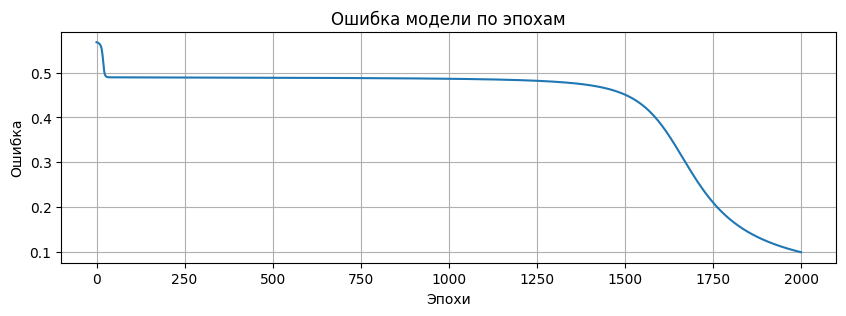

In [53]:
# Визуализация ошибок
train_plot(errors)
plt.show()

Функция получения предиктов (предсказаний модели) тоже поменяется:

In [54]:
# Функция для тестирования после обучения
def predict_2(input_data, w_input_hidden1, w_hidden1_hidden2, w_hidden2_output):
    hidden_layer1_input = np.dot(input_data, w_input_hidden1)  # Прямой проход через первый скрытый слой
    hidden_layer1_output = sigmoid(hidden_layer1_input)  # Активация первого скрытого слоя
    
    hidden_layer2_input = np.dot(hidden_layer1_output, w_hidden1_hidden2)  # Прямой проход через второй скрытый слой
    hidden_layer2_output = sigmoid(hidden_layer2_input)  # Активация второго скрытого слоя

    final_input = np.dot(hidden_layer2_output, w_hidden2_output)  # Прямой проход к выходу
    final_output = sigmoid(final_input)  # Активация выходного слоя

    return final_output

In [55]:
# Прогнозы
predictions_3 = predict_2(X_test, w_input_hidden1, w_hidden1_hidden2, w_hidden2_output)

In [56]:
rounded_predictions_3 = np.round(predictions_3)  # Округление предсказаний до 0 или 1

In [57]:
# Вывод предсказаний и реальных меток в виде таблицы
df_3 = pd.DataFrame({
    "Показания светофора (One-Hot)": [str(row) for row in test_data],
    "Прогноз (вероятность)": predictions_3.flatten(),
    "Результат модели (разрешено движение/запрещено)": rounded_predictions_3.flatten(),
    "Правильный результат": y
})

In [58]:
df_3

,Показания светофора (One-Hot),Прогноз (вероятность),Результат модели (разрешено движение/запрещено),Правильный результат
0,[1 0 0 0 0 0],0.886115,1.0,1
1,[0 1 0 0 0 0],0.884450,1.0,1
2,[0 0 1 0 0 0],0.084160,0.0,0
3,[0 0 0 1 0 0],0.891739,1.0,1
4,[0 0 0 0 1 0],0.103038,0.0,0
5,[0 0 0 0 0 1],0.113567,0.0,0
6,[0 0 1 0 1 0],0.054189,0.0,0


In [59]:
acc = accuracy(y_test, predictions_3.flatten())
print(f'Accuracy: {acc:.3f}')

rec = recall(y_test, predictions_3.flatten())
print(f'Recall: {rec:.3f}')

prec = precision(y_test, predictions_3.flatten())
print(f'Precision: {prec:.3f}')

f1 = f1__score(y_test, predictions_3.flatten())
print(f'F1 Score: {f1:.3f}')

Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


# Использование библиотеки Tensorflow

Для ускорения разработки и упрощения работы с нейронными сетями часто используют специализированные библиотеки, такие как **TensorFlow**. Она позволяет автоматизировать многие процессы создания и обучения модели, избавляя от необходимости вручную прописывать математику прямого и обратного прохода.

**Создание модели с TensorFlow**

С помощью TensorFlow легко создать модель. В данном примере используется последовательная модель (Sequential), где слои добавляются последовательно.

Здесь добавляется скрытый слой с 16 нейронами и функцией активации ReLU, а также выходной слой с функцией активации - сигмоидой.

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [61]:
# Создаем модель
model = Sequential()
# Добавляем слои
model.add(Dense(16, input_dim=6, activation='relu'))  # Скрытый слой с 16 нейронами
model.add(Dense(1, activation='sigmoid'))  # Выходной слой

Компиляция и обучение модели
После создания структуры модели её необходимо скомпилировать. Будем использовать функцию потерь binary_crossentropy и оптимизатор Adam, который адаптивно подстраивает скорость обучения:

In [62]:
# Компилируем модель
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
# вывод информации по архитектуре созданной модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


Модель обучается на данных, используя небольшие батчи (по 1 примеру за итерацию) и за 200 эпох:

In [64]:
epochs = 50
batch_size = 1

In [65]:
# Данные: светофор (зеленый, желтый, красный) закодированы как One-Hot векторы
X = np.array([
    [1, 0, 0, 0, 0, 0],  # Зеленый
    [0, 1, 0, 0, 0, 0],  # Зеленый мигающий
    [0, 0, 1, 0, 0, 0],  # Желтый
    [0, 0, 0, 1, 0, 0],  # Желтый мигающий
    [0, 0, 0, 0, 1, 0],  # Красный
    [0, 0, 0, 0, 0, 1],  # Красный мигающий
    [0, 0, 1, 0, 0, 1],  # Красный и желтый
])

In [66]:
# Метки: движение разрешено (1) или запрещено (0)
y = np.array([
    1,  # Зеленый: движение разрешено
    1,  # Зеленый мигающий: движение разрешено
    0,  # Желтый: движение запрещено
    1,  # Желтый мигающий: движение разрешено
    0,  # Красный: движение запрещено
    0,  # Красный мигающий: движение запрещено
    0   # Красный и желтый: движение запрещено
])

In [67]:
# Обучаем модель
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

In [68]:
def plot_model_accuracy_loss(history):
    '''
    функция визуализации процесса обучения: точности Accuracy и ошибки Loss
    '''
    plt.figure(figsize=(12, 4))

    # график точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # график ошибки
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()   

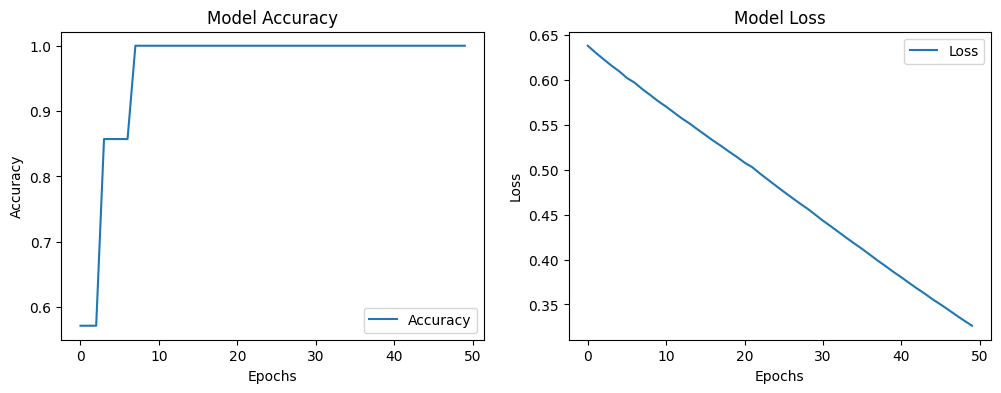

In [69]:
# визуализация процесса обучения (точности и ошибки)
plot_model_accuracy_loss(history)

In [70]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Прогнозы на обучающих данных
predictions_TF = model.predict(X)
rounded_predictions_TF = np.round(predictions_TF)

# Оценка метрик
accuracy_TF = accuracy_score(y, rounded_predictions_TF)
recall_TF = recall_score(y, rounded_predictions_TF)
precision_TF = precision_score(y, rounded_predictions_TF)
f1_TF = f1_score(y, rounded_predictions_TF)

# Вывод результатов
print(f'Accuracy: {accuracy_TF:.3f}')
print(f'Recall: {recall_TF:.3f}')
print(f'Precision: {precision_TF:.3f}')
print(f'F1 Score: {f1_TF:.3f}')

1/1 [==============================] - 0s 41ms/step
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


# Шокируем модель чокнутым светофором

Чтобы проверить устойчивость нашей модели, мы вводим не существующие комбинации сигналов светофора — такие, которые противоречат логике, например, одновременно горят зелёный и красный свет. Такие тесты помогают выявить, как модель справляется с некорректными или непредсказуемыми данными.

**Нестандартные данные**

Мы подаем на вход модели тестовые данные с нелогичными комбинациями сигналов:


In [71]:
# Прогнозы
X_test_data = np.array([
    [1, 0, 0, 0, 1, 0],  # Зеленый и Красный
    [0, 1, 0, 0, 0, 1],  # Зеленый мигающий и Красный мигающий
    [1, 0, 1, 0, 1, 0],  # Зеленый, Желтый и Красный
    [0, 1, 0, 1, 0, 1],  # Желтый мигающий, Зеленый мигающий и Красный мигающий
    [0, 0, 0, 0, 1, 0],  # Красный
    [1, 0, 0, 0, 0, 0],  # Зеленый
    [0, 0, 0, 0, 0, 0]   # Ничего не горит
])

In [72]:
# метки
y_test_data = np.array([
    [0],  # Зеленый и Красный: запрещено
    [0],  # Зеленый мигающий и Красный мигающий: запрещено
    [0],  # Зеленый, Желтый и Красный: запрещено
    [1],  # Желтый мигающий, Зеленый мигающий и Красный мигающий: запрещено
    [0],  # Красный: запрещено
    [1],  # Зеленый: разрешено
    [1]   # Ничего не горит: разрешено
])

In [73]:
# Загрузка модели
weights_input_hidden, weights_hidden_output = load_model("model_continued.pkl")

Модель загружена из файла: model_continued.pkl


In [74]:
predictions_4 = predict(X_test_data, weights_input_hidden, weights_hidden_output)
rounded_predictions_4 = np.round(predictions_4)  # Округление предсказаний до 0 или 1

In [75]:
rounded_predictions_4

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.]])

In [76]:
# Вывод предсказаний и реальных меток в виде таблицы
df = pd.DataFrame({
    "Показания светофора (One-Hot)": [str(row) for row in test_data],
    "Прогноз (вероятность)": predictions_4.flatten(),
    "Результат модели (разрешено движение/запрещено)": rounded_predictions_4.flatten(),
    "Правильный результат": y_test_data.flatten()
})

In [77]:
df

,Показания светофора (One-Hot),Прогноз (вероятность),Результат модели (разрешено движение/запрещено),Правильный результат
0,[1 0 0 0 0 0],0.434168,0.0,0
1,[0 1 0 0 0 0],0.477584,0.0,0
2,[0 0 1 0 0 0],0.019496,0.0,0
3,[0 0 0 1 0 0],0.949565,1.0,1
4,[0 0 0 0 1 0],0.023355,0.0,0
5,[0 0 0 0 0 1],0.976843,1.0,1
6,[0 0 1 0 1 0],0.573090,1.0,1


In [78]:
acc = accuracy(y_test_data, predictions_4)
print(f'Accuracy: {acc:.3f}')

rec = recall(y_test_data, predictions_4)
print(f'Recall: {rec:.3f}')

prec = precision(y_test_data, predictions_4)
print(f'Precision: {prec:.3f}')

f1 = f1__score(y_test_data, predictions_4)
print(f'F1 Score: {f1:.3f}')

Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


**Оценка качества модели**

Модель хорошо распознает "чокнутые" сигналы светофора, особенно в предсказаниях, где движение разрешено. Однако, её способность не пропускать положительные сигналы могла бы быть выше. Метрики показывают, что модель может столкнуться с трудностями при обработке необычных сигналов светофора, но всё ещё делает разумные предсказания в большинстве случаев.
